In [3]:
import rpy2
import json
import os
import glob
import re
from pprint import pprint
import numpy as np
import pandas as pd

%load_ext rpy2.ipython
%R require("ggplot2")
%R require("data.table")
%R require("stringr")

Loading required package: ggplot2
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘ggplot2’


Loading required package: data.table
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘data.table’


Loading required package: stringr
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘stringr’


In [6]:
# infer_model = 'llama3_1-8b-base'
# infer_model = 'llama3-8b-base'
# infer_model = 'llama3-70b-base'
# infer_model = 'qwen2-72b-base'
# infer_model = 'pythia-1_4b-base'
infer_model = 'pythia-410m-base'

# face_type = 'raw'
face_type = 'zscore'

face_real = False
face_real = 'real_' if face_real else ''

df = pd.read_csv(f'./results/face_est-{infer_model}_{face_type}_{face_real}result.csv')
df_2 = pd.read_csv(f'./results/face_est-{infer_model}_raw_real_result.csv')

# replace df's SO, CORR, SPEAR with df_2's
df['so'] = df_2['so']
df['corr'] = df_2['corr']
df['spear'] = df_2['spear']

legend_name = {'so': 'SO', 'corr': 'CORR', 'spear': 'SPEAR', 'emd': 'EMD', 'kl': 'KL', 'js': 'JS', 'surprisal': 'Surprisal', 'mauve': 'MAUVE', 'zipf': 'Zipf'}
columns = df.columns.tolist()
columns[0] = 'Model'
columns[-1] = 'Human'
for i, col in enumerate(columns[1:-1]):
    columns[i+1] = legend_name[col]
df.columns = columns
df.set_index('Model', inplace=True)

df.loc['gpt-4', 'Human'] = 0.492317
df.loc['claude-v1', 'Human'] = 0.241965
df.loc['gpt-3.5-turbo', 'Human'] = 0.174441
df.loc['vicuna-13b-v1.2', 'Human'] = 0.065548
df.loc['alpaca-13b', 'Human'] = 0.019645
df.loc['llama-13b', 'Human'] = 0.006085

df.loc['alpaca-13b', 'MAUVE'] = 0.3249
df.loc['claude-v1', 'MAUVE'] = 0.2868
df.loc['gpt-3.5-turbo', 'MAUVE'] = 0.6441
df.loc['llama-13b', 'MAUVE'] = 0.1490
df.loc['vicuna-13b-v1.2', 'MAUVE'] = 0.7075

df.loc['vicuna-13b-v1.2', 'Zipf'] = 0.0145
df.loc['llama-13b', 'Zipf'] = 0.0140
df.loc['gpt-3.5-turbo', 'Zipf'] = 0.0140
df.loc['alpaca-13b', 'Zipf'] = 0.0132
df.loc['claude-v1', 'Zipf'] = 0.0126

df.loc['gpt-3.5-turbo', 'Bert Score'] = 0.017806
df.loc['vicuna-13b-v1.2', 'Bert Score'] = 0.006758
df.loc['claude-v1', 'Bert Score'] = 0.004040
df.loc['alpaca-13b', 'Bert Score'] = 0.002431
df.loc['llama-13b', 'Bert Score'] = 0.000541

df.loc['gpt-3.5-turbo', 'Bart Score'] = 0.019497
df.loc['claude-v1', 'Bart Score'] = 0.006669
df.loc['vicuna-13b-v1.2', 'Bart Score'] = 0.004376
df.loc['alpaca-13b', 'Bart Score'] = 0.000694
df.loc['llama-13b', 'Bart Score'] = 0.000207

# exclude gpt-4
df.drop('gpt-4', inplace=True)

# normalize
for col in df.columns:
    df[col] = df[col] / df[col].sum()

df.sort_values(by='Human', ascending=False, inplace=True)
df.head()

,SO,CORR,SPEAR,EMD,KL,JS,Surprisal,Human,MAUVE,Zipf,Bert Score,Bart Score
Model,,,,,,,,,,,,
claude-v1,0.275462,0.272707,0.143626,0.211278,0.150621,0.159414,0.100046,0.476606,0.135776,0.184480,0.127945,0.212098
gpt-3.5-turbo,0.328295,0.323716,0.218284,0.360705,0.273663,0.275619,0.275316,0.343602,0.304928,0.204978,0.563909,0.620074
vicuna-13b-v1.2,0.260216,0.283670,0.179068,0.242767,0.209502,0.227269,0.414881,0.129112,0.334943,0.212299,0.214023,0.139172
alpaca-13b,0.078505,0.070101,0.230199,0.117643,0.217288,0.193142,0.084003,0.038695,0.153813,0.193265,0.076989,0.022072
llama-13b,0.057521,0.049806,0.228823,0.067607,0.148926,0.144555,0.125754,0.011986,0.070539,0.204978,0.017133,0.006583


SO: r=0.92, p=0.08
CORR: r=0.87, p=0.13
SPEAR: r=-0.21, p=0.79
EMD: r=0.97, p=0.03
KL: r=0.87, p=0.13
JS: r=0.93, p=0.07


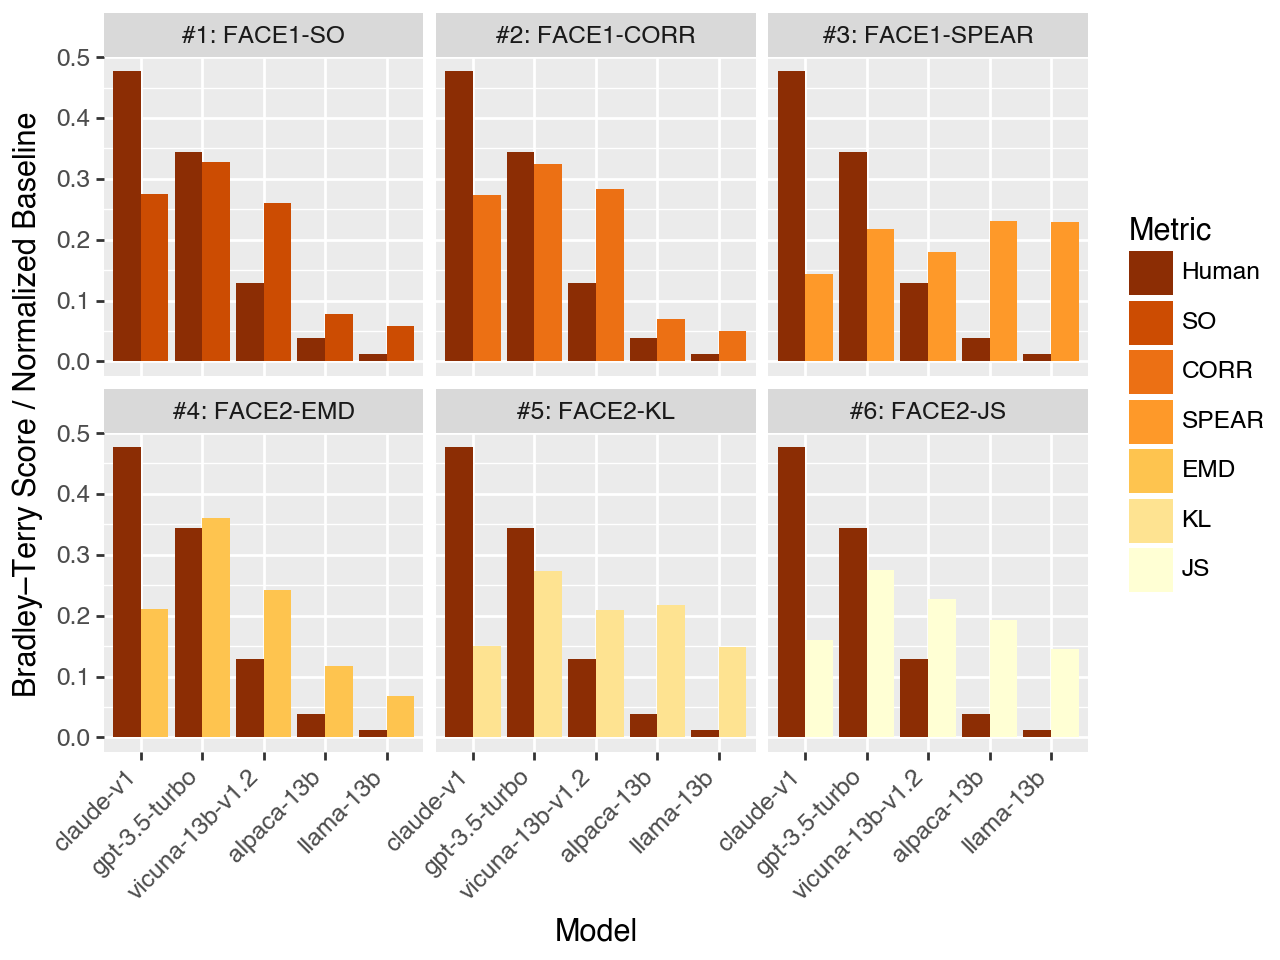

/Users/xy/.pyenv/versions/3.12.11/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/xy/.pyenv/versions/3.12.11/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ./figures/face_est-pythia-410m-base_zscore_FACE.pdf


Surprisal: r=0.52, p=0.48
MAUVE: r=0.74, p=0.26
Zipf: r=0.30, p=0.70
Bert Score: r=1.00, p=0.00
Bart Score: r=0.99, p=0.01


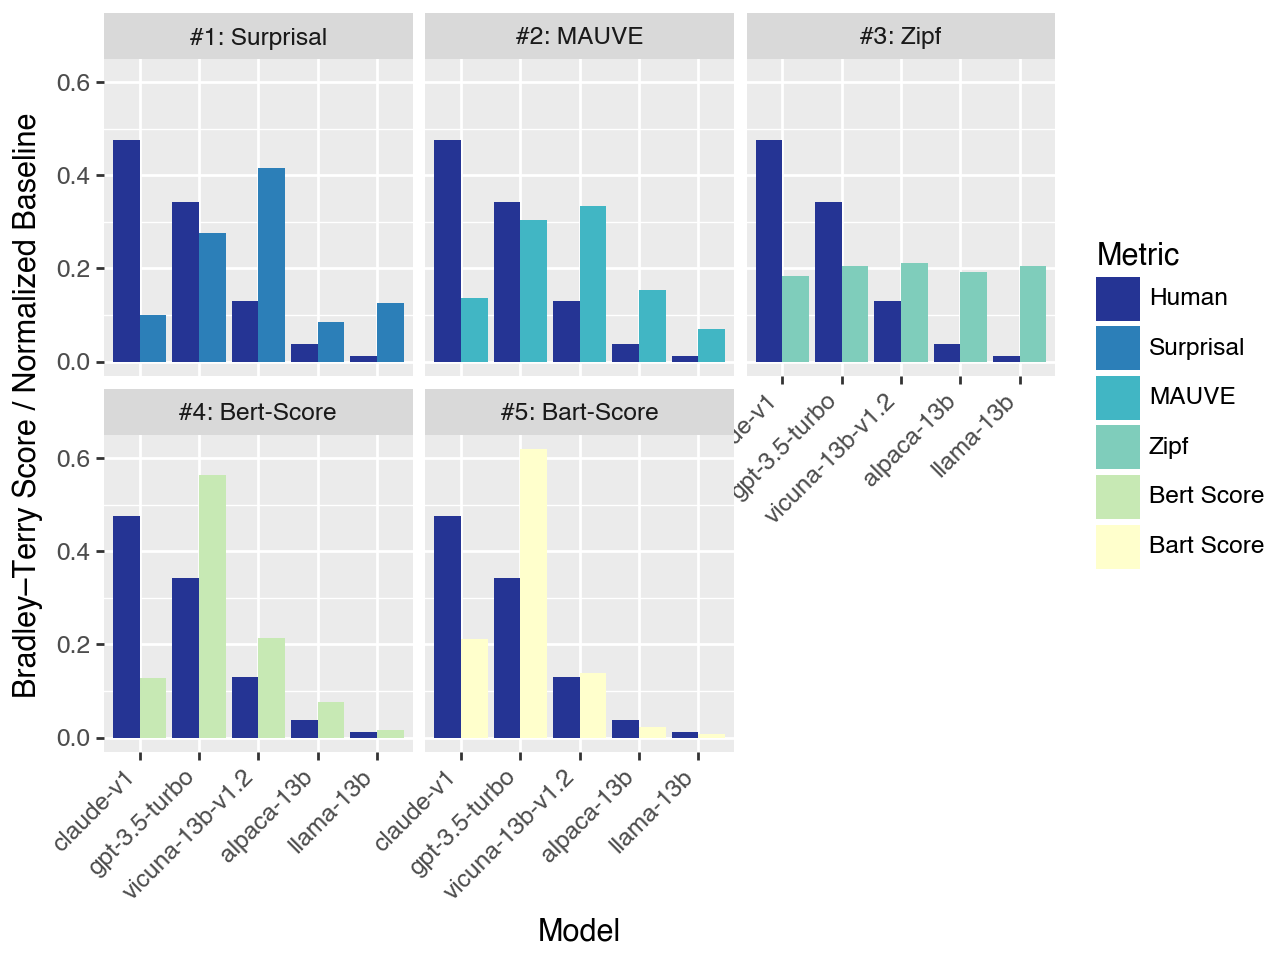

/Users/xy/.pyenv/versions/3.12.11/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/xy/.pyenv/versions/3.12.11/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ./figures/face_est-pythia-410m-base_zscore_Others.pdf


In [8]:
from plotnine import ggplot, geom_bar, aes, theme, element_text, scale_fill_manual, facet_wrap, scale_fill_brewer, scale_fill_discrete
from scipy.stats import pearsonr

facet_order = {'SO': '1', 'CORR': '2', 'SPEAR': '3', 'EMD': '4', 'KL': '5', 'JS': '6', 'Surprisal': '1', 'MAUVE': '2', 'Zipf': '3', 'Bert Score': '4', 'Bart Score': '5'}
facet_name = {'SO': 'FACE1-SO', 'CORR': 'FACE1-CORR', 'SPEAR': 'FACE1-SPEAR', 'EMD': 'FACE2-EMD', 'KL': 'FACE2-KL', 'JS': 'FACE2-JS', 'Surprisal': 'Surprisal', 'MAUVE': 'MAUVE', 'Zipf': 'Zipf', 'Bert Score': 'Bert-Score', 'Bart Score': 'Bart-Score'}

df_plot_1 = df.drop(columns=['Surprisal', 'MAUVE', 'Zipf', 'Bert Score', 'Bart Score'])
df_plot_2 = df.drop(columns=['SO', 'CORR', 'SPEAR', 'EMD', 'KL', 'JS'])

# double bar plot, one for each metric, one for human
df_human = df['Human'].to_dict()
all_records = []
for col in df_plot_1.columns:
    if col == 'Human':
        continue
    df_col = df[col]

    # pearson between model and human
    col_values = []
    human_values = []
    for model, value in df_col.items():
        if model == 'claude-v1':
            continue
        # print(model)
        col_values.append(value)
    for model, value in df_human.items():
        if model == 'claude-v1':
            continue
        human_values.append(value)
    r, p = pearsonr(col_values, human_values)
    # print(col_values)
    # print(human_values)
    print(f'{col}: r={r:.2f}, p={p:.2f}')

    # make 2-variable dataframe
    records = []
    for model, value in df_col.items():
        records.append({'Model': model, 'Bradley–Terry Score / Normalized Baseline': value, 'Metric': col, 'facet': '#' + facet_order[col] + ': ' + facet_name[col]})# + f' (r={r:.2f}, p={p:.2f})'})
        col_values.append(value)
    for model, value in df_human.items():
        records.append({'Model': model, 'Bradley–Terry Score / Normalized Baseline': value, 'Metric': 'Human', 'facet': '#' + facet_order[col] + ': ' + facet_name[col]})# + f' (r={r:.2f}, p={p:.2f})'})
        human_values.append(value)
    all_records.extend(records)
    df_plot = pd.DataFrame.from_records(records)

    # sort model by human
    df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df_plot_1.sort_values(by='Human', ascending=False).index, ordered=True)
    # human is always the first
    df_plot['Metric'] = pd.Categorical(df_plot['Metric'], categories=['Human', col], ordered=True)
    # plot = ggplot(df_plot, aes(x='Model', y='Bradley–Terry Score / Normalized Baseline', fill='Metric')) + geom_bar(stat='identity', position='dodge') + theme(axis_text_x=element_text(angle=45, hjust=1)) + scale_fill_manual(values=['#db5e57', '#57d3db'])
    # plot.show()
    # plot.save(f'./figures/face_est-{infer_model}_{face_type}_{face_real}{col}.pdf')

df_plot = pd.DataFrame.from_records(all_records)
# sort model by human
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df_plot_1.sort_values(by='Human', ascending=False).index, ordered=True)
# human is always the first
df_plot['Metric'] = pd.Categorical(df_plot['Metric'], categories=['Human', 'SO', 'CORR', 'SPEAR', 'EMD', 'KL', 'JS'], ordered=True)
plot = ggplot(df_plot, aes(x='Model', y='Bradley–Terry Score / Normalized Baseline', fill='Metric')) + geom_bar(stat='identity', position='dodge') + theme(axis_text_x=element_text(angle=45, hjust=1)) + facet_wrap('facet') + scale_fill_brewer(palette=17, direction=-1) # + scale_fill_manual(values=['#db5e57', '#57d3db'])
plot.show()
plot.save(f'./figures/face_est-{infer_model}_{face_type}_{face_real}FACE.pdf')

all_records = []
for col in df_plot_2.columns:
    if col == 'Human':
        continue
    df_col = df[col]

    # pearson between model and human
    col_values = []
    human_values = []
    for model, value in df_col.items():
        if model == 'claude-v1':
            continue
        # print(model)
        col_values.append(value)
    for model, value in df_human.items():
        if model == 'claude-v1':
            continue
        human_values.append(value)
    r, p = pearsonr(col_values, human_values)
    # print(col_values)
    # print(human_values)
    print(f'{col}: r={r:.2f}, p={p:.2f}')

    # make 2-variable dataframe
    records = []
    for model, value in df_col.items():
        records.append({'Model': model, 'Bradley–Terry Score / Normalized Baseline': value, 'Metric': col, 'facet': '#' + facet_order[col] + ': ' + facet_name[col]})# + f' (r={r:.2f}, p={p:.2f})'})
        col_values.append(value)
    for model, value in df_human.items():
        records.append({'Model': model, 'Bradley–Terry Score / Normalized Baseline': value, 'Metric': 'Human', 'facet': '#' + facet_order[col] + ': ' + facet_name[col]})# + f' (r={r:.2f}, p={p:.2f})'})
        human_values.append(value)
    all_records.extend(records)
    df_plot = pd.DataFrame.from_records(records)

    # sort model by human
    df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df_plot_2.sort_values(by='Human', ascending=False).index, ordered=True)
    # human is always the first
    df_plot['Metric'] = pd.Categorical(df_plot['Metric'], categories=['Human', col], ordered=True)
    # plot = ggplot(df_plot, aes(x='Model', y='Bradley–Terry Score / Normalized Baseline', fill='Metric')) + geom_bar(stat='identity', position='dodge') + theme(axis_text_x=element_text(angle=45, hjust=1)) + scale_fill_manual(values=['#db5e57', '#57d3db'])
    # plot.show()
    # plot.save(f'./figures/face_est-{infer_model}_{face_type}_{face_real}{col}.pdf')
    
df_plot = pd.DataFrame.from_records(all_records)
# sort model by human
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df_plot_2.sort_values(by='Human', ascending=False).index, ordered=True)
# human is always the first
df_plot['Metric'] = pd.Categorical(df_plot['Metric'], categories=['Human', 'Surprisal', 'MAUVE', 'Zipf', 'Bert Score', 'Bart Score'], ordered=True)
plot = ggplot(df_plot, aes(x='Model', y='Bradley–Terry Score / Normalized Baseline', fill='Metric')) + geom_bar(stat='identity', position='dodge') + theme(axis_text_x=element_text(angle=45, hjust=1)) + facet_wrap('facet') + scale_fill_brewer(palette=16, direction=-1) # + scale_fill_manual(values=['#db5e57', '#57d3db'])
plot.show()
plot.save(f'./figures/face_est-{infer_model}_{face_type}_{face_real}Others.pdf')

In [ ]:
records = []
for col in df.columns:
    for model, value in df[col].items():
        records.append({'Model': model, 'Bradley–Terry Score': value, 'Metric': col})

df_plot = pd.DataFrame.from_records(records)
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df.sort_values(by='Human', ascending=False).index, ordered=True)
plot = ggplot(df_plot, aes(x='Model', y='Bradley–Terry Score', fill='Metric')) + geom_bar(stat='identity', position='dodge') + theme(axis_text_x=element_text(angle=45, hjust=1))
plot.show()